# Práctica Final: Google Play Store
Realizado por:
Andres Puente y Francisco Solano López-Bleda

----
## Planteamiento
El objetivo de este proyecto es entrenar a una red neuronal para poder predecir el rating de una aplicación basado en el input que le aportemos

Sidequests que pueden estar guapas:
- Generar comentarios de bots automáticos, basandonons en otros comentarios


## Datos

### Descripción de los datos

#### `googleplaystore.csv`
Contiene información de las aplicaciones alojadas en Google Play Store hasta el 8 de agosto de 2018. Este fichero se usará principalmente para conocer la información de la app. Nos proveerá toda la información necesaria para poder predecir el rating de una aplicación.

| App                       | Category  | Rating                  | Reviews           | Size                     | Installs                | Type                             | Price  | Content Rating          | Genres                  | Last Updated          | Current Ver     | Android Ver                         |
|---------------------------|-----------|-------------------------|-------------------|--------------------------|-------------------------|----------------------------------|--------|-------------------------|-------------------------|-----------------------|-----------------|-------------------------------------|
|  Nombre App | Categoría | Rating de la aplicación | Número de reviews |  Tamaño | Número de instalaciones | paid or free | Precio | Putuacion del contenido | Género de la aplicación |  Última actualización |  Versión actual | Mínima version de Android soportada |

#### `googleplaystore_user_reviews.csv` 
Contiene información de las reviews de las aplicaciones alojadas en Google Play Store hasta el 8 de agosto de 2018. Este fichero se podrá usar usará para poder capturar reviews falsas, así cruzando datos de este dataset y el anterior también podremos predecir el porcentaje de reviews falsas.

| App | Translated_Review | Sentiment | Sentiment_Polarity | Sentiment_Subjectivity |
|--------------------------|-------------------------|--------------------------------------|-------------------------|----------------------------|
| Nombre de la Applicación | Traducción de la review | Opinion: Positiva, Negativa o Neutra | Polaridad de la opinión | Subjetividad de la opinion |

## Imports

In [63]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn import metrics

## Data

### Lectura de los datos - Representacion de los tipos de datos

In [64]:
data = pd.read_csv('data/googleplaystore.csv')
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 13 columns):
App               9360 non-null object
Category          9360 non-null object
Rating            9360 non-null float64
Reviews           9360 non-null object
Size              9360 non-null object
Installs          9360 non-null object
Type              9360 non-null object
Price             9360 non-null object
Content Rating    9360 non-null object
Genres            9360 non-null object
Last Updated      9360 non-null object
Current Ver       9360 non-null object
Android Ver       9360 non-null object
dtypes: float64(1), object(12)
memory usage: 1023.8+ KB


### Lectura de los datos - Visualizacion

Visualizacion de los datos de los 5 primeros elementos

In [65]:
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


## Transformacion de los datos

Para poder llevar a cabo un buen algoritmo de machine learning transformaremos los datos a int/float cuando sea posible para generar una mejor coorrelacion entre los datos.

Aquellos datos que no se consideren necesarios o relevantes para la aproximacion seran desechados.

In [66]:
#Transformacion de las categorias a int
CategoryString = data["Category"]
categoryVal = data["Category"].unique()
categoryValCount = len(categoryVal)
category_dict = {}
for i in range(0, categoryValCount):
    category_dict[categoryVal[i]] = i
data["Category_i"] = data["Category"].map(category_dict).astype(int)

In [67]:
#Transformacion y limpieza del tamaño de instalacion
def sizes_trans(size):
    if 'M' in size:
        x = size[:-1]
        x = float(x)*1000000
        return(x)
    elif 'k' == size[-1:]:
        x = size[:-1]
        x = float(x)*1000
        return(x)
    else:
        return None
    
data["Size"] = data["Size"].map(sizes_trans)

#Rellenando los vacios
data.Size.fillna(method = 'ffill', inplace = True)

In [68]:
#Transformacion del número de descargas(Installs)
def installs_trans(inst):
    try:
        x = (inst[:-1].replace(",",""))
        x = int(x)
        #return x
    except ValueError:
        print("Line is corrupt!", x)
        x = 0
    return x


data["Installs"] = data["Installs"].map(installs_trans)

#data["Installs"] = [(i[:-1].replace(",","")) for i in data["Installs"]]
#data["Installs"] = data["Installs"].astype(float)

In [69]:
#Transformacion del Tipo de app(Free/No Free) a binario
def type_trans(types):
    if types == 'Free':
        return 0
    else:
        return 1
    
data["Type"] = data["Type"].map(type_trans)

In [70]:
#Transformacion del "Content Rating" a enteros por cada valor unico
RatingL = data["Content Rating"].unique()
RatingDict = {}
for i in range(len(RatingL)):
    RatingDict[RatingL[i]] = i
    
data["Content Rating"] = data["Content Rating"].map(RatingDict).astype(int)

In [71]:
#Transformacion de los "Genres" a int
GenresL = data.Genres.unique()
GenresDict = {}
for i in range(len(GenresL)):
    GenresDict[GenresL[i]] = i
    
data["Genres_i"] = data["Genres"].map(GenresDict).astype(int)

In [72]:
#Transformar Fecha a numero
test_date = "August 2, 2018"
import datetime
def date_trans(date_str):
    date_time_obj = datetime.datetime.strptime(date_str, '%B %d, %Y')
    return date_time_obj.timestamp()
data["Last Updated"] = data["Last Updated"].map(date_trans).astype(float)

In [73]:
#Transformacion de los precios a int
def price_trans(price):
    if price == '0':
        return 0
    else:
        price = price[1:]
        if price == "veryone":
            price = 0
        price = float(price)
        return price
    
data["Price"] = data["Price"].map(price_trans).astype(float)

In [74]:
#Transformacion de las reviews a float

def review_trans(rev):
    if 'M' in rev:
        x = rev[:-1]
        x = float(x)*1000000
        return(x)
    elif 'k' == rev[-1:]:
        x = rev[:-1]
        x = float(x)*1000
        return(x)
    else:
        return rev

data["Reviews"] = data["Reviews"].map(review_trans).astype(float)

In [75]:
#Eliminando los parametros que no utilizaremos ya que no son relevantes
data.drop(labels = ["Last Updated","Current Ver", 'Android Ver', 'App'], axis = 1, inplace = True)

In [76]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 11 columns):
Category          9360 non-null object
Rating            9360 non-null float64
Reviews           9360 non-null float64
Size              9360 non-null float64
Installs          9360 non-null int64
Type              9360 non-null int64
Price             9360 non-null float64
Content Rating    9360 non-null int32
Genres            9360 non-null object
Category_i        9360 non-null int32
Genres_i          9360 non-null int32
dtypes: float64(4), int32(3), int64(2), object(2)
memory usage: 767.8+ KB


In [77]:
data.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Category_i,Genres_i
0,ART_AND_DESIGN,4.1,159.0,19000000.0,10000,0,0.0,0,Art & Design,0,0
1,ART_AND_DESIGN,3.9,967.0,14000000.0,500000,0,0.0,0,Art & Design;Pretend Play,0,1
2,ART_AND_DESIGN,4.7,87510.0,8700000.0,5000000,0,0.0,0,Art & Design,0,0
3,ART_AND_DESIGN,4.5,215644.0,25000000.0,50000000,0,0.0,1,Art & Design,0,0
4,ART_AND_DESIGN,4.3,967.0,2800000.0,100000,0,0.0,0,Art & Design;Creativity,0,2


## Dummies

In [78]:
data2 = pd.get_dummies(data, columns=["Category"])

In [79]:
data2.head()

,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Category_i,Genres_i,...,Category_PERSONALIZATION,Category_PHOTOGRAPHY,Category_PRODUCTIVITY,Category_SHOPPING,Category_SOCIAL,Category_SPORTS,Category_TOOLS,Category_TRAVEL_AND_LOCAL,Category_VIDEO_PLAYERS,Category_WEATHER
0,4.1,159.0,19000000.0,10000,0,0.0,0,Art & Design,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.9,967.0,14000000.0,500000,0,0.0,0,Art & Design;Pretend Play,0,1,...,0,0,0,0,0,0,0,0,0,0
2,4.7,87510.0,8700000.0,5000000,0,0.0,0,Art & Design,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4.5,215644.0,25000000.0,50000000,0,0.0,1,Art & Design,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4.3,967.0,2800000.0,100000,0,0.0,0,Art & Design;Creativity,0,2,...,0,0,0,0,0,0,0,0,0,0


In [80]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9360 entries, 0 to 10840
Data columns (total 43 columns):
Rating                          9360 non-null float64
Reviews                         9360 non-null float64
Size                            9360 non-null float64
Installs                        9360 non-null int64
Type                            9360 non-null int64
Price                           9360 non-null float64
Content Rating                  9360 non-null int32
Genres                          9360 non-null object
Category_i                      9360 non-null int32
Genres_i                        9360 non-null int32
Category_ART_AND_DESIGN         9360 non-null uint8
Category_AUTO_AND_VEHICLES      9360 non-null uint8
Category_BEAUTY                 9360 non-null uint8
Category_BOOKS_AND_REFERENCE    9360 non-null uint8
Category_BUSINESS               9360 non-null uint8
Category_COMICS                 9360 non-null uint8
Category_COMMUNICATION          9360 non-null uint8

## Gráficas guays

In [81]:
#Evaluacion de matriz
def Evaluationmatrix(y_true, y_predict):
    print ('Mean Squared Error: '+ str(metrics.mean_squared_error(y_true,y_predict)))
    print ('Mean absolute Error: '+ str(metrics.mean_absolute_error(y_true,y_predict)))
    print ('Mean squared Log Error: '+ str(metrics.mean_squared_log_error(y_true,y_predict)))

#to add into results_index for evaluation of error term 
def Evaluationmatrix_dict(y_true, y_predict, name = 'Linear - Integer'):
    dict_matrix = {}
    dict_matrix['Series Name'] = name
    dict_matrix['Mean Squared Error'] = metrics.mean_squared_error(y_true,y_predict)
    dict_matrix['Mean Absolute Error'] = metrics.mean_absolute_error(y_true,y_predict)
    dict_matrix['Mean Squared Log Error'] = metrics.mean_squared_log_error(y_true,y_predict)
    return dict_matrix

## Hace Calculos
### Excluye el genero

In [82]:
#excluding Genre label
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split

#Integer encoding
X = data.drop(labels = ['Category','Rating','Genres','Genres_i'],axis = 1)
y = data.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
model = LinearRegression()
model.fit(X_train,y_train)
Results = model.predict(X_test)

#Creation of results dataframe and addition of first entry
resultsdf = pd.DataFrame()
resultsdf = resultsdf.from_dict(Evaluationmatrix_dict(y_test,Results),orient = 'index')
resultsdf = resultsdf.transpose()

#dummy encoding

X_d = data2.drop(labels = ['Rating','Genres','Category_i','Genres_i'],axis = 1)
y_d = data2.Rating
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.30)
model_d = LinearRegression()
model_d.fit(X_train_d,y_train_d)
Results_d = model_d.predict(X_test_d)

#adding results into results dataframe
resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test_d,Results_d, name = 'Linear - Dummy'),ignore_index = True)

#### Dibujooooos

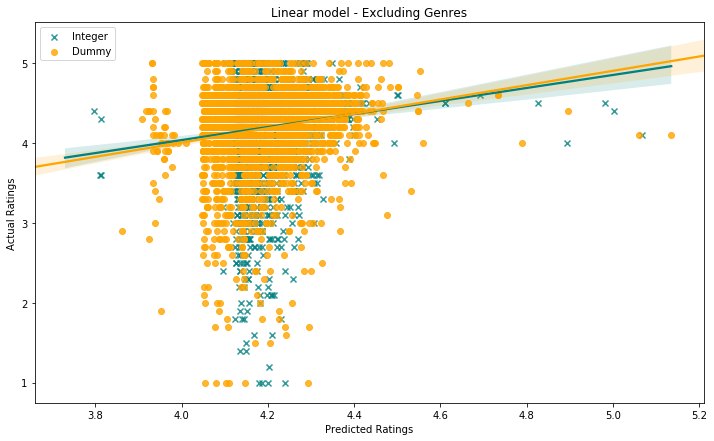

In [83]:
import seaborn as sns


plt.figure(figsize=(12,7))
sns.regplot(Results,y_test,color='teal', label = 'Integer', marker = 'x')
sns.regplot(Results_d,y_test_d,color='orange',label = 'Dummy')
plt.legend()
plt.title('Linear model - Excluding Genres')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()



In [84]:
print ('Actual mean of population:' + str(y.mean()))
print ('Integer encoding(mean) :' + str(Results.mean()))
print ('Dummy encoding(mean) :'+ str(Results_d.mean()))
print ('Integer encoding(std) :' + str(Results.std()))
print ('Dummy encoding(std) :'+ str(Results_d.std()))

Actual mean of population:4.191837606837612
Integer encoding(mean) :4.192155984172339
Dummy encoding(mean) :4.195299721709749
Integer encoding(std) :0.06708251035231264
Dummy encoding(std) :0.10255119091853283


### Incluye el genero

In [85]:
#Including genre label

#Integer encoding
X = data.drop(labels = ['Category','Rating','Genres'],axis = 1)
y = data.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
model = LinearRegression()
model.fit(X_train,y_train)
Results = model.predict(X_test)

resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,Results, name = 'Linear(inc Genre) - Integer'),ignore_index = True)

#dummy encoding

X_d = data2.drop(labels = ['Rating','Genres','Category_i'],axis = 1)
y_d = data2.Rating
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.30)
model_d = LinearRegression()
model_d.fit(X_train_d,y_train_d)
Results_d = model_d.predict(X_test_d)

resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test_d,Results_d, name = 'Linear(inc Genre) - Dummy'),ignore_index = True)

#### Dibujoooos

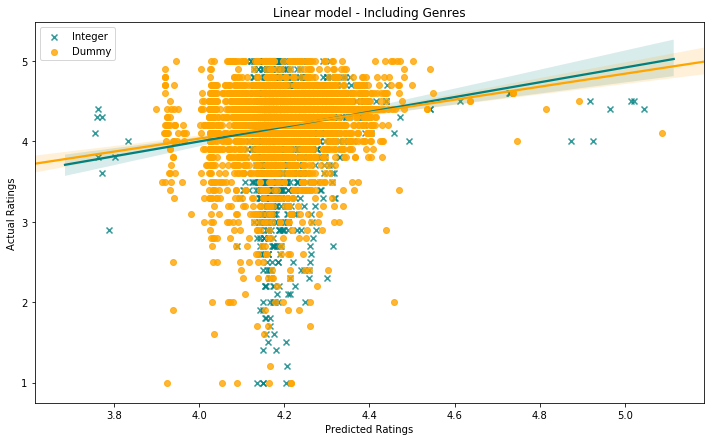

In [86]:
plt.figure(figsize=(12,7))
sns.regplot(Results,y_test,color='teal', label = 'Integer', marker = 'x')
sns.regplot(Results_d,y_test_d,color='orange',label = 'Dummy')
plt.legend()
plt.title('Linear model - Including Genres')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [87]:
print ('Integer encoding(mean) :' + str(Results.mean()))
print ('Dummy encoding(mean) :'+ str(Results_d.mean()))
print ('Integer encoding(std) :' + str(Results.std()))
print ('Dummy encoding(std) :'+ str(Results_d.std()))

Integer encoding(mean) :4.198336641812031
Dummy encoding(mean) :4.1933349075885
Integer encoding(std) :0.0711073004501085
Dummy encoding(std) :0.10854664339427172


Texto explicando lo de arriba

## Ahora con SVR
Descripcion de lo que va a pasar

### Excluyendo Generos

In [88]:
#Excluding genres
from sklearn import svm
#Integer encoding

X = data.drop(labels = ['Category','Rating','Genres','Genres_i'],axis = 1)
y = data.Rating
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

model2 = svm.SVR()
model2.fit(X_train,y_train)

Results2 = model2.predict(X_test)

resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test,Results2, name = 'SVM - Integer'),ignore_index = True)

#dummy based


X_d = data2.drop(labels = ['Rating','Genres','Category_i','Genres_i'],axis = 1)
y_d = data2.Rating

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.30)

model2 = svm.SVR()
model2.fit(X_train_d,y_train_d)

Results2_d = model2.predict(X_test_d)

resultsdf = resultsdf.append(Evaluationmatrix_dict(y_test_d,Results2_d, name = 'SVM - Dummy'),ignore_index = True)

C:\Users\franc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\franc\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


#### Dibujooos

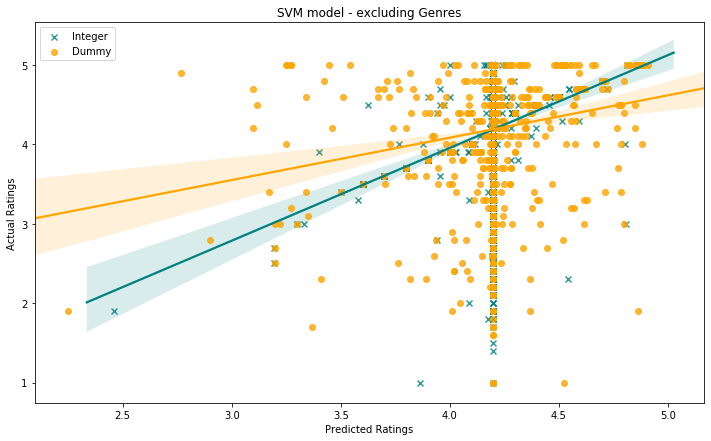

In [89]:
plt.figure(figsize=(12,7))
sns.regplot(Results2,y_test,color='teal', label = 'Integer', marker = 'x')
sns.regplot(Results2_d,y_test_d,color='orange',label = 'Dummy')
plt.legend()
plt.title('SVM model - excluding Genres')
plt.xlabel('Predicted Ratings')
plt.ylabel('Actual Ratings')
plt.show()

In [90]:
print ('Integer encoding(mean) :' + str(Results2.mean()))
print ('Dummy encoding(mean) :'+ str(Results2_d.mean()))
print ('Integer encoding(std) :' + str(Results2.std()))
print ('Dummy encoding(std) :'+ str(Results2_d.std()))

Integer encoding(mean) :4.1965297250576326
Dummy encoding(mean) :4.198112114359605
Integer encoding(std) :0.08399217911794372
Dummy encoding(std) :0.14494657344355072
